In [12]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from collections import defaultdict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Import functions from qualitative_analysis
from qualitative_analysis.data_processing import load_data, clean_and_normalize, sanitize_dataframe
from qualitative_analysis.model_interaction import get_llm_client
from qualitative_analysis.evaluation import compute_cohens_kappa
from qualitative_analysis.utils import save_results_to_csv, load_results_from_csv
import qualitative_analysis.config as config
from qualitative_analysis.prompt_construction import construct_prompt
from qualitative_analysis.prompt_construction import build_data_format_description
from qualitative_analysis.response_parsing import extract_code_from_response
from qualitative_analysis.cost_estimation import openai_api_calculate_cost


In [13]:
# Define data directory
data_dir = 'data'
os.makedirs(data_dir, exist_ok=True)

In [14]:
# Define the path to your dataset
data_file_path = os.path.join(data_dir, 'binary_sample.csv')

# Load the data
data = load_data(data_file_path, file_type='csv', delimiter=';')

# Preview the data
data.head()

,ID,ref,txt1.ctrl1,txt1.det,txt1.exp,txt1.ctrl2,corr_cycle1
0,BC23,"À des dizaines de kilomètres sous nos pieds, l...","Le manteau,le centre de la Terre",Je pense que le manteau et le centre de la Ter...,Le manteau et le centre de la Terre ne font il...,Je n'ai pas pu trouver la réponse à ma question.,1
1,BC14,"À des dizaines de kilomètres sous nos pieds, l...",Température du magma,La température du magma s'élève à plus de 100...,à combien de °cle magma est?,La température du magma atteint les 1000 °C,1
2,BC5,"À des dizaines de kilomètres sous nos pieds, l...",Pourqoi on l'appelle le manteau.,le magma et une pierre.,quel et la temperature magma,1 000c,0
3,BC22,"À des dizaines de kilomètres sous nos pieds, l...",La température du magma,La température du magma dépasse les 500 °C,Quel est la température du magma ?,La température du magma atteint les 1000 °C,1
4,BC20,"À des dizaines de kilomètres sous nos pieds, l...",Combien de couches y-t-il ?,Il existe d'autre couches dans la terre à par...,Quelles sont les autres couches et combien son...,La terre contient 7 couches dont le noyau.,1


In [15]:
# 1) Define a mapping from old column names to new names
rename_map = {
    "ref": "reference",
    "txt1.ctrl1": "Identify",
    "txt1.det": "Guess",
    "txt1.exp": "Seek",
    "txt1.ctrl2": "Assess"
}

# 2) Rename the columns in the DataFrame
data = data.rename(columns=rename_map)

# 3) Now define the new column names for cleaning
text_columns = ["reference", "Identify", "Guess", "Seek", "Assess"]

# 4) Clean and normalize the new columns
for col in text_columns:
    data[col] = clean_and_normalize(data[col])

# 5) Sanitize the DataFrame
data = sanitize_dataframe(data)


c:\Users\ocler\Documents\Académique\Inria\qualitative_analysis_project\qualitative_analysis\data_processing.py:134: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return df.applymap(


In [16]:
# Combine texts and entries

data['verbatim'] = data.apply(
    lambda row: (
        f"Reference: {row['reference']}\n\n"
        f"Identify: {row['Identify']}\n"
        f"Guess: {row['Guess']}\n"
        f"Seek: {row['Seek']}\n"
        f"Assess: {row['Assess']}"
    ),
    axis=1
)

# Extract the list of verbatims
verbatims = data['verbatim'].tolist()

print(f"Total number of verbatims: {len(verbatims)}")
print(f"Verbatim example:\n{verbatims[0]}")

Total number of verbatims: 45
Verbatim example:
Reference: À des dizaines de kilomètres sous nos pieds, la terre contient une couche quon appelle le manteau. Il fait tellement chaud sur cette couche que les roches deviennent liquides : cest ce qu'on appelle le magma. Le magma est responsable de l'explosion des volcans: c'est ce que les scientifiques appellent aussi une éruption d'un volcan. On dit quun volcan est endormi sil ny a eu aucune éruption dans les 10 000 dernières années. Au delà de 10 000 ans, on peut dire que le volcan est éteint.

Identify: Le manteau,le centre de la Terre
Guess: Je pense que le manteau et le centre de la Terre sont les màames choses
Seek: Le manteau et le centre de la Terre ne font ils qu'un?
Assess: Je n'ai pas pu trouver la réponse à  ma question.


In [17]:
# Choose the provider and model
provider = 'azure'
model_name = 'gpt-4o'

# Initialize the client
llm_client = get_llm_client(provider=provider, config=config.MODEL_CONFIG[provider])

In [23]:
# Define column descriptions
column_descriptions = {
    "ID": "Unique identifier for each entry",
    "reference": "The reference text that participants must read beforehand. Their responses for the different steps must be semantically related to this text (same topic), but the answer to the question they are asking should not be found in the text.",
    "Identify": "Response for the IDENTIFY step",
    "Guess": "Response for the GUESS step",
    "Seek": "Response for the SEEK step",
    "Assess": "Response for the ASSESS step"
}

# Define criteria as themes
codebook = {
    "Identify Step": "Does the Identify step indicate a topic of interest?",
    "Guess Step": "Does the Guess step suggest a possible explanation?",
    "Seek Step": "Is the Seek step formulated as a question?",
    "Assess Step": "Does it identify a possible answer or state that no answer was found ('no' is ok)?",
    "Consistency": "Are the Identify, Guess, and Seek steps related to the same question?",
    "Reference Link": "Are the Identify, Guess, and Seek steps related to the topic of the reference text?",
    "Seek Question Originality": "Is the answer to the Seek question not found (even vaguely) in the reference text?",
}

data_format_description = build_data_format_description(column_descriptions)

# Classification settings
reasoning = True  # If True, perform two-step reasoning. If False, single-step classification.

# Define queries for binary classification and reasoning
binary_query = "Reply with '1' if the entry meets the criterion or '0' otherwise."
reasoning_query = "First, generate a one-sentence reasoning about the classification."

# Select subset of verbatims for testing
verbatims_subset = verbatims[:5]

def construct_prompt(verbatim, theme, theme_description):
    """
    Constructs the base prompt for the given verbatim and theme.
    """
    prompt = f"""
You are a helpful assistant tasked with evaluating the following entry.

You are provided with data entries in the following format:

{data_format_description}

**Entry:**
{verbatim}

**Criterion:**
{theme} - {theme_description}
"""
    return prompt.strip()

def generate_with_reasoning(llm_client, model_name, base_prompt, reasoning=False, temperature=0.0001, verbose=False):
    """
    Generates a classification result. 
    If reasoning is False, make one API call:
        Base prompt + binary_query
    If reasoning is True, make two API calls:
        1) Base prompt + reasoning_query
        2) Base prompt + reasoning_answer_from_first_call + binary_query
    """
    if reasoning:
        # First call: get reasoning
        first_prompt = f"{base_prompt}\n\n{reasoning_query}"
        print("=== First LLM Prompt (Reasoning) ===")

        response_text_1, usage_1 = llm_client.get_response(
            prompt=first_prompt,
            model=model_name,
            max_tokens=500,
            temperature=temperature,
            verbose=True
        )

        print("\n=== LLM Response (Reasoning) ===")
        print(response_text_1)

        # Second call: use reasoning answer for classification
        second_prompt = f"{base_prompt}\n\nReasoning:\n{response_text_1}\n\n{binary_query}"
        print("\n=== Second LLM Prompt (Classification) ===")

        response_text_2, usage_2 = llm_client.get_response(
            prompt=second_prompt,
            model=model_name,
            max_tokens=500,
            temperature=temperature,
            verbose=True
        )

        print("\n=== LLM Response (Classification) ===")
        print(response_text_2)

        # Combine usage stats
        usage_1.prompt_tokens += usage_2.prompt_tokens
        usage_1.completion_tokens += usage_2.completion_tokens
        usage_1.total_tokens += usage_2.total_tokens

        return response_text_2, usage_1
    
    else:
        # Single-step classification: base prompt + binary_query
        single_prompt = f"{base_prompt}\n\n{binary_query}"
        print("=== Single-step Classification Prompt ===")

        response_text, usage = llm_client.get_response(
            prompt=single_prompt,
            model=model_name,
            max_tokens=500,
            temperature=temperature,
            verbose=True
        )
        
        print("\n=== LLM Response (Single-step Classification) ===")
        print(response_text)

        return response_text, usage

# Initialize results and cost tracking
results = []
verbatim_costs = []
total_tokens_used = 0
total_cost = 0

for idx, verbatim in enumerate(verbatims_subset):
    print(f"\n=== Processing Verbatim {idx + 1}/{len(verbatims_subset)} ===")
    verbatim_tokens_used = 0  # Track tokens for this verbatim
    verbatim_cost = 0  # Track cost for this verbatim

    # Binary classification processing
    for theme, theme_description in codebook.items():
        print(f"\n--- Evaluating Theme: {theme} ---")

        # Build the base prompt
        base_prompt = construct_prompt(
            verbatim=verbatim, 
            theme=theme, 
            theme_description=theme_description
        )

        try:
            response_content, usage = generate_with_reasoning(
                llm_client=llm_client,
                model_name=model_name,
                base_prompt=base_prompt,
                reasoning=reasoning,
                temperature=0.0001,
                verbose=True  # Set to True to enable prompt and response printing
            )

            # Track token usage
            if usage:
                prompt_tokens = usage.prompt_tokens
                completion_tokens = usage.completion_tokens
                total_tokens = usage.total_tokens

                # Calculate the cost for this request
                cost = openai_api_calculate_cost(usage, model=model_name)
                total_tokens_used += total_tokens
                total_cost += cost
                verbatim_tokens_used += total_tokens
                verbatim_cost += cost

                # Print detailed token usage and cost
                print(f"\nTokens Used: {prompt_tokens} (prompt) + {completion_tokens} (completion) = {total_tokens} total")
                print(f"Cost for Theme '{theme}': ${cost:.4f}")

            # Parse response
            score = extract_code_from_response(response_content)
            if score in [0, 1]:
                results.append({
                    'Verbatim': verbatim,
                    'Theme': theme,
                    'Score': score
                })
                print(f"Extracted Score for '{theme}': {score}")
            else:
                print(f"Failed to parse a valid score for '{theme}'")
                results.append({
                    'Verbatim': verbatim,
                    'Theme': theme,
                    'Score': None
                })

        except Exception as e:
            print(f"Error processing Verbatim {idx + 1} for Theme '{theme}': {e}")
            results.append({
                'Verbatim': verbatim,
                'Theme': theme,
                'Score': None
            })

    # Store verbatim-level cost
    verbatim_costs.append({'Verbatim': verbatim, 'Tokens Used': verbatim_tokens_used, 'Cost': verbatim_cost})

# Final Summary
print("\n=== Processing Complete ===")
print(f"Total Tokens Used: {total_tokens_used}")
print(f"Total Cost for Processing: ${total_cost:.4f}")

# Organize scores by verbatim for binary classification
verbatim_scores = defaultdict(dict)
for entry in results:
    verbatim = entry['Verbatim']
    theme = entry['Theme']
    score = entry['Score']
    verbatim_scores[verbatim][theme] = score

# Determine overall validity
final_results = []
for verbatim, scores in verbatim_scores.items():
    overall_validity = 1  # Assume valid
    for theme, score in scores.items():
        if score != 1:
            overall_validity = 0
            break
    final_results.append({
        'Verbatim': verbatim,
        'Overall_Validity': overall_validity
    })

# Optionally, print the final results
for result in final_results:
    print(result)



=== Processing Verbatim 1/5 ===

--- Evaluating Theme: Identify Step ---
=== First LLM Prompt (Reasoning) ===
Prompt:
You are a helpful assistant tasked with evaluating the following entry.

You are provided with data entries in the following format:

The data has the following columns:
- "ID": Unique identifier for each entry
- "reference": The reference text that participants must read beforehand. Their responses for the different steps must be semantically related to this text (same topic), but the answer to the question they are asking should not be found in the text.
- "Identify": Response for the IDENTIFY step
- "Guess": Response for the GUESS step
- "Seek": Response for the SEEK step
- "Assess": Response for the ASSESS step


**Entry:**
Reference: À des dizaines de kilomètres sous nos pieds, la terre contient une couche quon appelle le manteau. Il fait tellement chaud sur cette couche que les roches deviennent liquides : cest ce qu'on appelle le magma. Le magma est responsa

In [24]:
# Convert results to DataFrame
results_df = pd.DataFrame(final_results)

# Define the save path
outputs_dir = os.path.join(data_dir, 'outputs')
os.makedirs(outputs_dir, exist_ok=True)
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
save_path = os.path.join(outputs_dir, f"experiment_{model_name.replace('/', '_')}_{timestamp}.csv")

# Save results
save_results_to_csv(
    coding=results_df.to_dict('records'),
    save_path=save_path,
    fieldnames=['Verbatim', 'Overall_Validity'],
    verbatims=None  # Verbatims are included in the results
)

Results saved to: data\outputs\experiment_gpt-4o-mini_20241220_143750.csv


In [25]:
# Load results
loaded_results = load_results_from_csv(save_path)
# The function returns (verbatims, coding)
verbatims_loaded, coding_loaded = loaded_results

Results loaded from: data\outputs\experiment_gpt-4o-mini_20241220_143750.csv


In [26]:
# Assuming you have human annotations in the data
human_annotations = data['corr_cycle1'].tolist()  # Replace with actual column name
model_coding = results_df['Overall_Validity'].tolist()

human_annotations_short = human_annotations[:5]

# Compute Cohen's Kappa
kappa = compute_cohens_kappa(
    human_annotations_short,
    model_coding,
    labels=[0, 1],
    weights='linear'
)

print(f"Cohen's Kappa Score between human annotations and model: {kappa:.2f}")

Cohen's Kappa Score between human annotations and model: 0.12


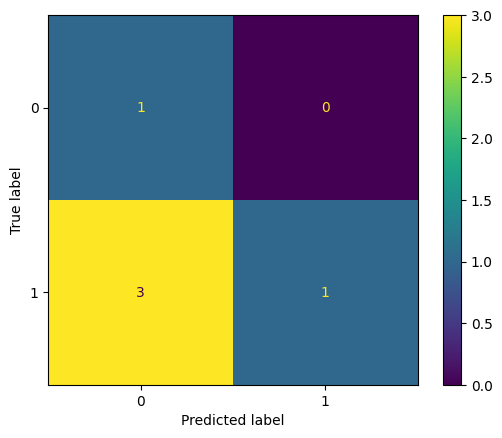

In [27]:
# Confusion Matrix
cm = confusion_matrix(human_annotations_short, model_coding, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()
plt.show()